# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
  1
  1
 -1
  1
  1
  1
 -1
  ⋮
  1
 -1
 -1
  1
  1
 -1
  1
  1
  1

### We create a function to visualize the data

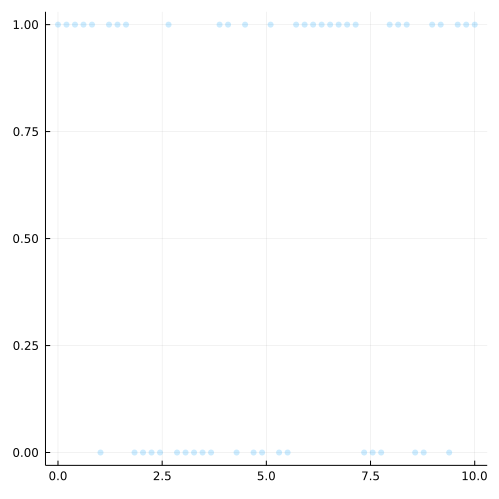

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.090788 seconds (1.82 M allocations: 103.780 MiB, 7.95% gc time, 99.49% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.2940073593765529, 1.3108567631982664, 1.2918869418276993, 1.230267135771532, 1.1250982767149427, 0.9834369426067042, 0.8237364032599418, 0.6802940727645316, 0.6055574941475049, 0.636557728289444  …  0.6136902845689615, 0.6190270154512371, 0.6362440597720719, 0.6695933535386709, 0.7202007284791576, 0.783789301294675, 0.8524309657656874, 0.9176256196268655, 0.9720022027557887, 1.0112906100476162], θ = [0.22011057501708742, 0.21944158669553154, 0.22019450247647043, 0.2226063900224354, 0.22658746767619606, 0.2316260844417258, 0.236761296360869, 0.24078458830631025, 0.24263053971932141, 0.2418868070801127  …  0.2424384894794685, 0.2423112761699544, 0.2418944900728644, 0.2410598872062675, 0.23972652413223014, 0.23794177801273084, 0.23588636772879407, 0.2338187359023747, 0.23201428833980267,

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:57
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:01
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:01
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:30
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:12
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:00
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:51
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[1.2277548352391874, 1.5613314340266964, 1.8278875036064417, 1.9346006298507916, 1.8899754631474652, 1.6691688297054066, 1.3281290438170315, 0.9309241691620116, 0.5406355290451208, 0.2591855450413286  …  1.2900341720466337, 1.2069168405623438, 1.0577614219331477, 0.9003787497602664, 0.7914617734028875, 0.6959772459981544, 0.674575579265137, 0.7000963343114129, 0.7662160402021659, 0.7801118481885763]]
 [[1.4055065817845027, 1.2067346893626167, 0.9693377328966757, 0.6626977290239222, 0.33167905960175414, -0.0029675043532192413, -0.32601329691234315, -0.596688751957271, -0.7942492023433487, -0.9379524608300817  …  -0.34791712550255677, -0.2697148546390414, -0.2105884068710297, -0.17012897794158977, -0.07773060945606253, 0.024412765925462376, 0.1218170003233005, 0.24284214881485222, 0.3019615995483619, 0.31704230659346283]]
 [[2.192108087207081, 1.9234722859471374, 1.5999625373512867, 1.257733484889628, 0.9322858369301465, 0.6254400848729834,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

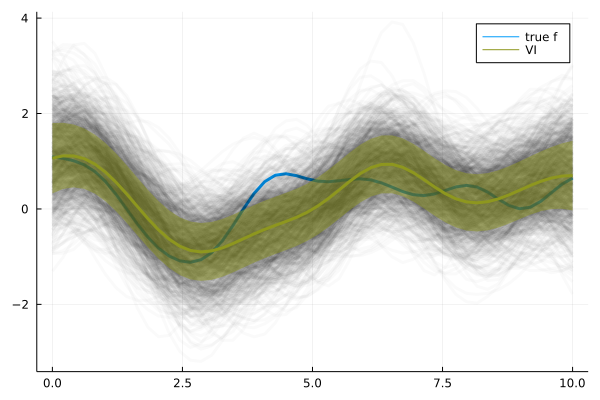

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

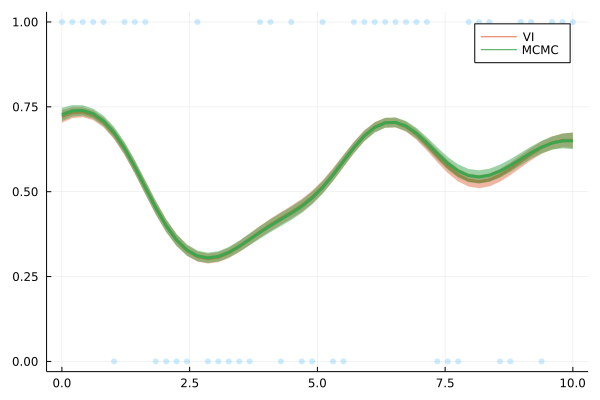

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*